Training on Experience 1
Epoch [10/50], Loss: 0.0013
Epoch [20/50], Loss: 0.0004
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0000
Epoch [50/50], Loss: 0.0000


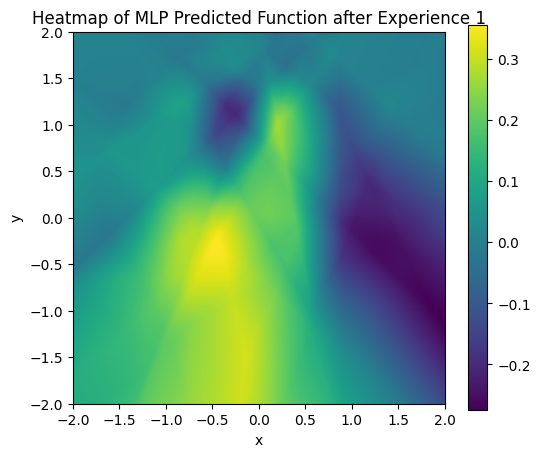

Training on Experience 2
Epoch [10/50], Loss: 0.0003
Epoch [20/50], Loss: 0.0002
Epoch [30/50], Loss: 0.0001
Epoch [40/50], Loss: 0.0002
Epoch [50/50], Loss: 0.0001


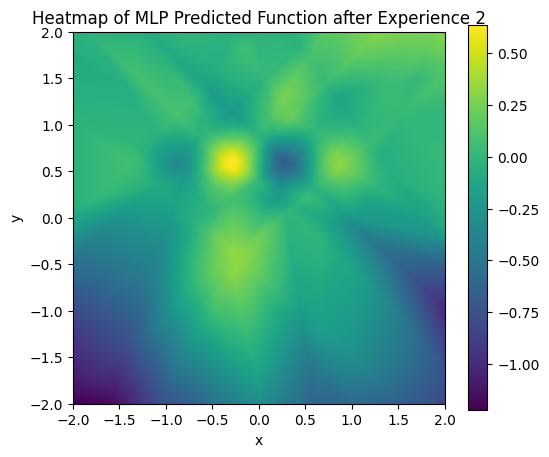

Training on Experience 3
Epoch [10/50], Loss: 0.0009
Epoch [20/50], Loss: 0.0004
Epoch [30/50], Loss: 0.0005
Epoch [40/50], Loss: 0.0004
Epoch [50/50], Loss: 0.0003


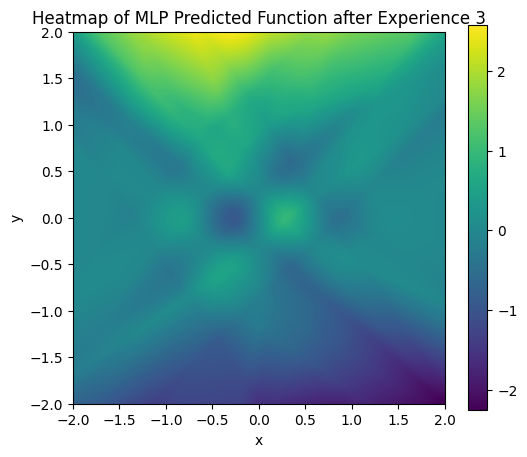

Training on Experience 4
Epoch [10/50], Loss: 0.0009
Epoch [20/50], Loss: 0.0006
Epoch [30/50], Loss: 0.0003
Epoch [40/50], Loss: 0.0003
Epoch [50/50], Loss: 0.0005


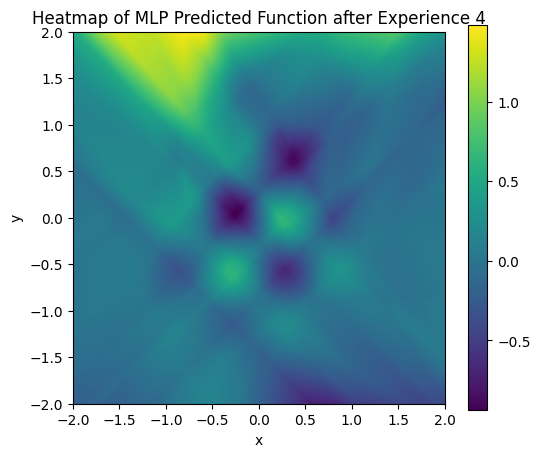

Training on Experience 5
Epoch [10/50], Loss: 0.0003
Epoch [20/50], Loss: 0.0002
Epoch [30/50], Loss: 0.0002
Epoch [40/50], Loss: 0.0003
Epoch [50/50], Loss: 0.0002


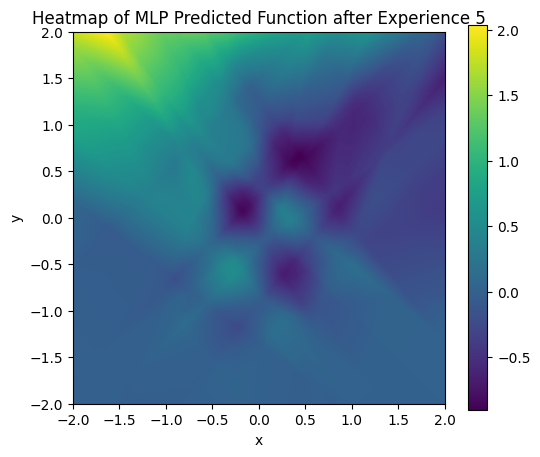

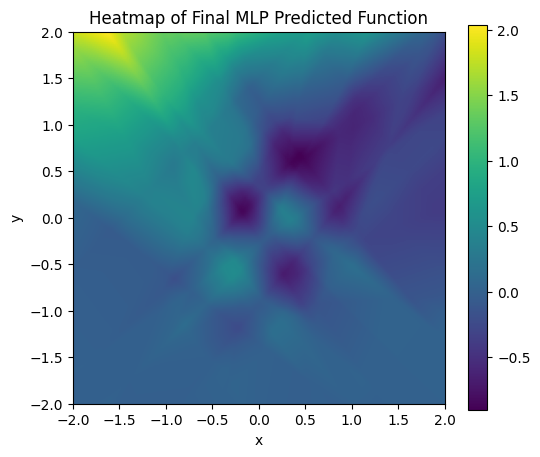

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Create a grid of points
n_points = 200
x = np.linspace(-2, 2, n_points)
y = np.linspace(-2, 2, n_points)
x_grid, y_grid = np.meshgrid(x, y)

# Define the complex 2D function
def complex_2d_function(x, y):
    return np.sin(5 * x) * np.cos(5 * y) * np.exp(-(x**2 + y**2))

# Generate the function values
f_xy = complex_2d_function(x_grid, y_grid)

# Prepare training data
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()
z_flat = f_xy.flatten()

# Create the input features as pairs of (x, y)
train_input = np.vstack((x_flat, y_flat)).T
train_label = z_flat

# Convert to PyTorch tensors
train_input_tensor = torch.tensor(train_input, dtype=torch.float32)
train_label_tensor = torch.tensor(train_label, dtype=torch.float32).view(-1, 1)

# Split data into 5 experiences
n_experiences = 5
experience_size = train_input_tensor.shape[0] // n_experiences

experience_train_data = []
experience_train_labels = []

for i in range(n_experiences):
    start_idx = i * experience_size
    end_idx = (i + 1) * experience_size
    experience_train_data.append(train_input_tensor[start_idx:end_idx])
    experience_train_labels.append(train_label_tensor[start_idx:end_idx])

# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function and optimizer
model = MLP()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation loop
num_epochs = 50
batch_size = 64

for i in range(n_experiences):
    print(f'Training on Experience {i + 1}')
    
    train_dataset = TensorDataset(experience_train_data[i], experience_train_labels[i])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(train_input_tensor.to(device)).cpu().numpy()
    
    # Reshape predictions to the original grid shape
    predictions_grid = predictions.reshape(x_grid.shape)
    
    # Plotting the predicted function
    plt.figure(figsize=(6, 5))
    plt.imshow(predictions_grid, cmap='viridis', extent=[-2, 2, -2, 2])
    plt.colorbar()
    plt.title(f'Heatmap of MLP Predicted Function after Experience {i + 1}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Final evaluation on the entire dataset
model.eval()
with torch.no_grad():
    final_predictions = model(train_input_tensor.to(device)).cpu().numpy()

# Reshape final predictions to the original grid shape
final_predictions_grid = final_predictions.reshape(x_grid.shape)

# Plotting the final predicted function
plt.figure(figsize=(6, 5))
plt.imshow(final_predictions_grid, cmap='viridis', extent=[-2, 2, -2, 2])
plt.colorbar()
plt.title('Heatmap of Final MLP Predicted Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



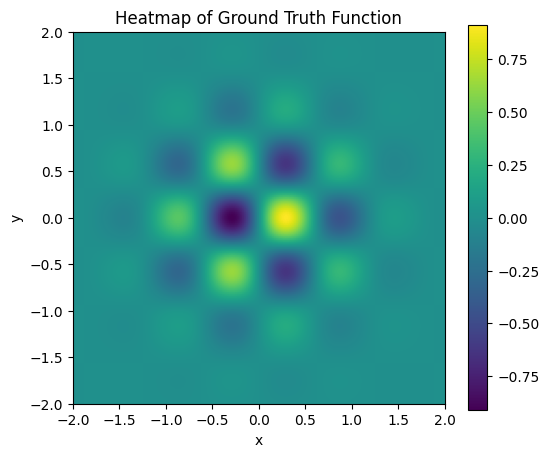

In [8]:

# Plotting the ground truth function
plt.figure(figsize=(6, 5))
plt.imshow(f_xy, cmap='viridis', extent=[-2, 2, -2, 2])
plt.colorbar()
plt.title('Heatmap of Ground Truth Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()